In [21]:
#%matplotlib notebook
import os
import matplotlib.pyplot as plt
import numpy as np
import lal
import lalsimulation as lalsim
import sys
sys.path.append('../scripts')
import compute_sigmalm0_SimIMREOBGenerateQNMFreqV2 as calcqnm
import scipy
import scipy.signal as ss
from scipy import interpolate
import scipy.ndimage.filters as filter
from optparse import OptionParser
import corner

In [22]:
# Module for confidence calculations
class confidence(object):
    def __init__(self, counts):
        # Sort in descending order in frequency
        self.counts_sorted = np.sort(counts.flatten())[::-1]
        # Get a normalized cumulative distribution from the mode
        self.norm_cumsum_counts_sorted = np.cumsum(self.counts_sorted) / np.sum(counts)
        # Set interpolations between heights, bins and levels
        self._set_interp()
    def _set_interp(self):
        self._length = len(self.counts_sorted)
        # height from index
        self._height_from_idx = interpolate.interp1d(np.arange(self._length), self.counts_sorted, bounds_error=False, fill_value=0.)
        # index from height
        self._idx_from_height = interpolate.interp1d(self.counts_sorted[::-1], np.arange(self._length)[::-1], bounds_error=False, fill_value=self._length)
        # level from index
        self._level_from_idx = interpolate.interp1d(np.arange(self._length), self.norm_cumsum_counts_sorted, bounds_error=False, fill_value=1.)
        # index from level
        self._idx_from_level = interpolate.interp1d(self.norm_cumsum_counts_sorted, np.arange(self._length), bounds_error=False, fill_value=self._length)
    def level_from_height(self, height):
        return self._level_from_idx(self._idx_from_height(height))
    def height_from_level(self, level):
        return self._height_from_idx(self._idx_from_level(level))

# gaussian filter of histogram
def gf(P):
    return filter.gaussian_filter(P, sigma=1.0)


# 
def P_xy_2dhist(x, y, N_bins):
    x_bins = np.linspace(min(x), max(x), N_bins)
    y_bins = np.linspace(min(y), max(y), N_bins)

    dx = np.mean(np.diff(x_bins))
    dy = np.mean(np.diff(y_bins))

    x_intp = (x_bins[:-1] + x_bins[1:])/2.
    y_intp = (y_bins[:-1] + y_bins[1:])/2.
    
    P_xy, x_bins, y_bins = np.histogram2d(x, y, bins=(x_bins, y_bins), normed=True)
    P_xy = P_xy.T
    
    conf = confidence(P_xy)
    s1 = conf.height_from_level(0.5)
    s2 = conf.height_from_level(0.9)
    
    return P_xy, x_intp, y_intp, s1, s2

# Pre- and post-bugfix

## S190521g

In [23]:
postbugfix_loc = '../runs/XLALSimInspiralChooseTDWaveformFromCache_runs/ligo_events/S190521g/C01/220/cbcBayes/posterior_samples.dat'
prebugfix_loc = '/home/abhirup.ghosh/public_html/LVC/O3/2019/May/21/1242442967p4500/G333631/lalinference/C01_runs/220/cbcBayes/posterior_samples.dat'

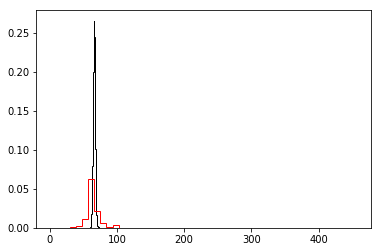

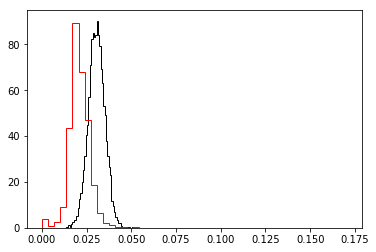

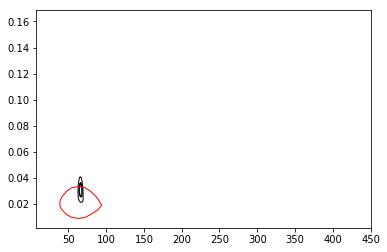

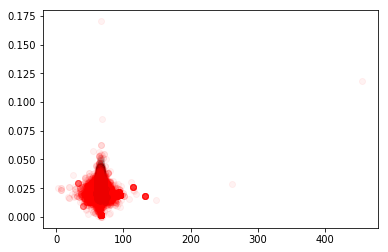

In [24]:
colors = ['k','r']

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)

fig4 = plt.figure()
ax4 = fig4.add_subplot(111)

for (idx, postloc) in enumerate([postbugfix_loc, prebugfix_loc]):
    data = np.genfromtxt(postloc, names=True, dtype=None)
    m1, m2, a1z, a2z, domega, dtau = data['m1'], data['m2'], data['a1z'], data['a2z'], data['domega220'], data['dtau220']
    lm = [2,2]

    # create (omega, tau) GR and modGRarrays
    omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
    freq_GR = omega_GR/(2.*np.pi)

    omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
    freq_modGR = omega_modGR/(2.*np.pi)

    f_seob = freq_modGR
    tau_seob = tau_modGR
    P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_seob, tau_seob, 50)
    
    ax1.hist(f_seob, bins=50, histtype='step', normed=True, color=colors[idx])
    ax2.hist(tau_seob, bins=50, histtype='step', normed=True, color=colors[idx])
    ax3.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors=colors[idx])
    ax4.scatter(f_seob, tau_seob, alpha=0.05, color=colors[idx])
    
plt.show()

## GW150914

In [25]:
postbugfix_loc = '../runs/XLALSimInspiralChooseTDWaveformFromCache_runs/ligo_events/GW150914/220/cbcBayes/posterior_samples.dat'
prebugfix_loc = '/home/abhirup.ghosh/public_html/LVC/spinqnm/runs/20190607_new_parameterisation/20190607_GW150914_domega220_dtau220/cbcBayes/posterior_samples.dat'

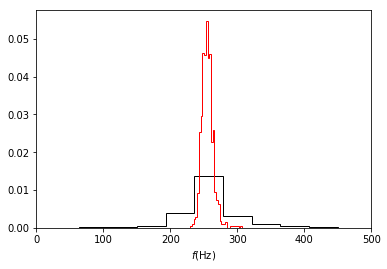

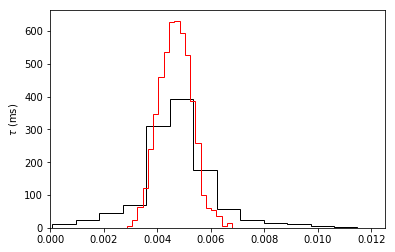

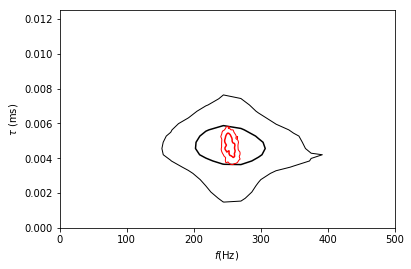

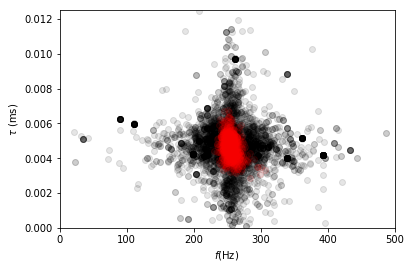

In [42]:
colors = ['k','r']

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)

fig4 = plt.figure()
ax4 = fig4.add_subplot(111)

for (idx, postloc) in enumerate([prebugfix_loc, postbugfix_loc]):
    data = np.genfromtxt(postloc, names=True, dtype=None)
    m1, m2, a1z, a2z, domega, dtau = data['m1'], data['m2'], data['a1z'], data['a2z'], data['domega220'], data['dtau220']
    lm = [2,2]

    # create (omega, tau) GR and modGRarrays
    omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
    freq_GR = omega_GR/(2.*np.pi)

    omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
    freq_modGR = omega_modGR/(2.*np.pi)

    f_seob = freq_modGR
    tau_seob = tau_modGR
    P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_seob, tau_seob, 50)
    
    ax1.hist(f_seob, bins=30, histtype='step', normed=True, color=colors[idx])
    ax1.set_xlim([0,500])
    ax1.set_xlabel("$f$(Hz)")
    ax2.hist(tau_seob, bins=20, histtype='step', normed=True, color=colors[idx])
    ax2.set_xlim([0,0.0125])
    ax2.set_ylabel(r"$\tau$ (ms)")
    ax3.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors=colors[idx])
    ax3.set_xlim([0,500])
    ax3.set_ylim([0,0.0125])
    ax3.set_xlabel("$f$(Hz)")
    ax3.set_ylabel(r"$\tau$ (ms)")
    ax4.scatter(f_seob, tau_seob, alpha=0.1, color=colors[idx])
    ax4.set_xlim([0,500])
    ax4.set_ylim([0,0.0125])
    ax4.set_xlabel("$f$(Hz)")
    ax4.set_ylabel(r"$\tau$ (ms)")
    
plt.show()